In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Using GPU
Epoch 1/1000

Epoch 1: val_accuracy improved from -inf to 0.11155, saving model to best_model.h5
197/197 - 6s - loss: 0.4131 - accuracy: 0.8702 - val_loss: 16.3744 - val_accuracy: 0.1115 - 6s/epoch - 32ms/step
Epoch 2/1000

Epoch 2: val_accuracy improved from 0.11155 to 0.11405, saving model to best_model.h5
197/197 - 5s - loss: 0.0973 - accuracy: 0.9697 - val_loss: 7.4561 - val_accuracy: 0.1140 - 5s/epoch - 24ms/step
Epoch 3/1000

Epoch 3: val_accuracy improved from 0.11405 to 0.95702, saving model to best_model.h5
197/197 - 5s - loss: 0.0680 - accuracy: 0.9786 - val_loss: 0.1553 - val_accuracy: 0.9570 - 5s/epoch - 24ms/step
Epoch 4/1000

Epoch 4: val_accuracy improved from 0.95702 to 0.97619, saving model to best_model.h5
197/197 - 5s - loss: 0.0575 - accuracy: 0.9814 - val_loss: 0.0864 - val_accuracy: 0.9762 - 5s/epoch - 24ms/step
Epoch 5/1000

Epoch 5: val_accuracy improved from 0.97619 to 0.98417, saving model to best_model.h5
197/197 - 5s - loss: 0.0475 - accuracy: 0.98

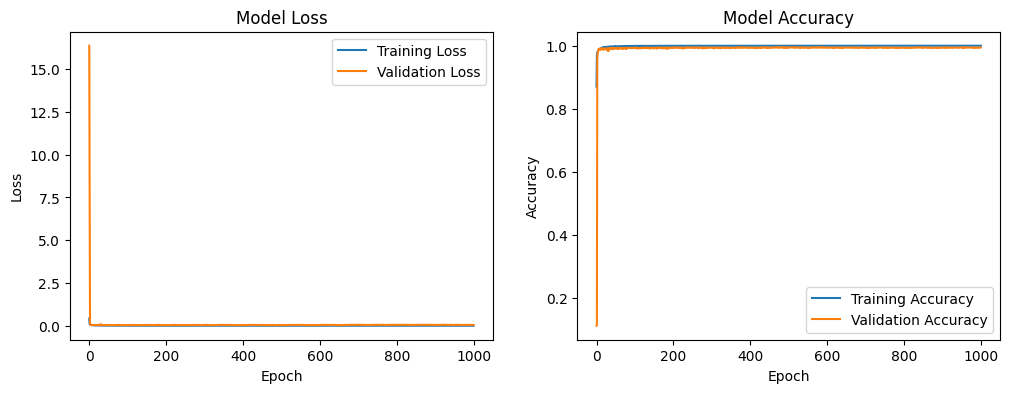

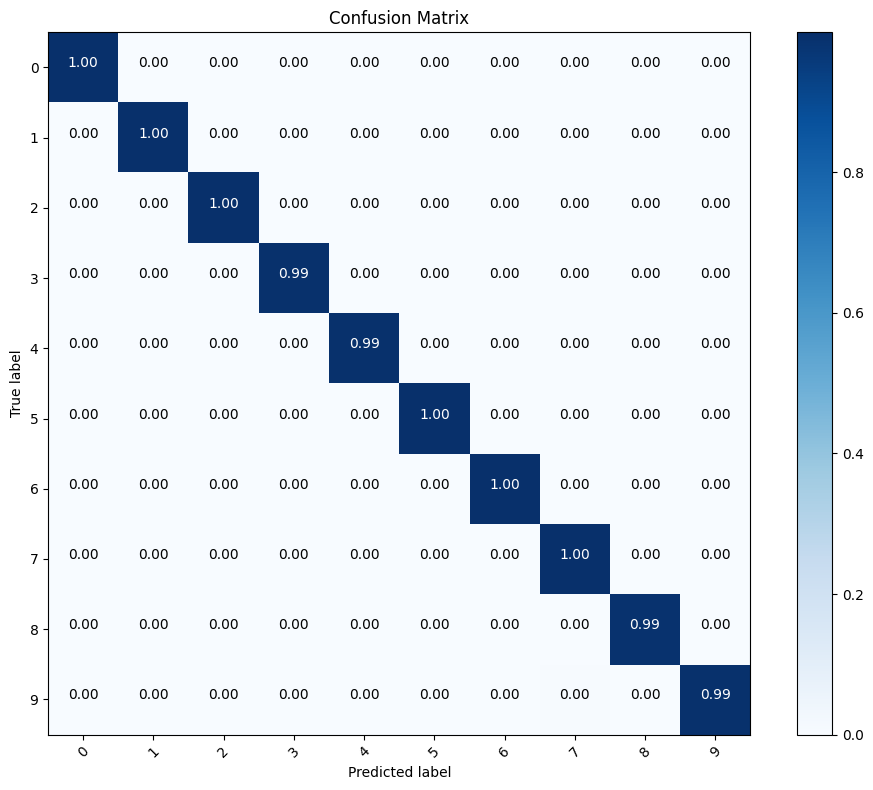

{'Test Accuracy': 0.9951785714285715, 'Training Loss': 5.0762453611241654e-05, 'Validation Loss': 0.047197628766298294}


In [39]:
class CNN2Wrapper:
    def __init__(self, X, y):
        """
        Initialize the CNN2Wrapper with training data.

        Parameters:
        X (np.ndarray): The training features.
        y (np.ndarray): The training labels.
        """
        self.X = X
        self.y = y
        self.results = {}
        self.history = None
        self.model = None
        self.best_model_path = 'best_model.h5'

    def prepare_data(self):
        """
        Prepare the data for training and testing.
        """
        lb = LabelBinarizer()
        y = lb.fit_transform(self.y)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, y, test_size=0.4, random_state=42, stratify=self.y)
        self.X_train = self.X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
        self.X_test = self.X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

    def create_cnn_model_2(self):
        """
        Create the second CNN model.
        """
        model = Sequential([
            Input(shape=(28, 28, 1)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.2),

            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.2),

            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.3),

            Conv2D(512, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.2),

            Flatten(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def evaluate_model(self):
        """
        Train and evaluate the CNN2 model.
        """
        self.prepare_data()
        self.model = self.create_cnn_model_2()
        
        # To ensure TensorFlow uses the GPU if available
        physical_devices = tf.config.list_physical_devices('GPU')
        if len(physical_devices) > 0:
            tf.config.experimental.set_memory_growth(physical_devices[0], True)
            print("Using GPU")
        else:
            print("No GPU found, using CPU")

        # Create a callback to save the best model based on validation accuracy
        checkpoint = ModelCheckpoint(self.best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

        self.history = self.model.fit(
            self.X_train, self.y_train,
            epochs=1000,
            validation_data=(self.X_test, self.y_test),
            callbacks=[checkpoint],
            verbose=2,
            batch_size=128
        )
        
        # Load the best model
        self.model = tf.keras.models.load_model(self.best_model_path)

        y_pred = self.model.predict(self.X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(self.y_test, axis=1)

        test_accuracy = accuracy_score(y_true, y_pred_classes)

        results = {
            "Test Accuracy": test_accuracy,
            "Training Loss": self.history.history['loss'][-1],
            "Validation Loss": self.history.history['val_loss'][-1]
        }

        self.results = results

        self.plot_history()
        self.plot_confusion_matrix(y_true, y_pred_classes)

    def plot_history(self):
        """
        Plot the training and validation loss and accuracy.
        """
        plt.figure(figsize=(12, 4))
        
        # Plot training & validation loss values
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred):
        """
        Plot the confusion matrix with proportions.
        """
        cm = confusion_matrix(y_true, y_pred, normalize='true')
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(np.unique(y_true)))
        plt.xticks(tick_marks, tick_marks, rotation=45)
        plt.yticks(tick_marks, tick_marks)

        fmt = '.2f'
        thresh = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

    def predict(self, X_new_df, save_csv=False):
        """
        Predict the class for new data and add a label column with the predicted class.

        Parameters:
        X_new_df (pd.DataFrame): The new data as a DataFrame.
        save_csv (bool): Whether to save the predictions as a CSV file.

        Returns:
        pd.DataFrame: The DataFrame with columns 'ImageId' and 'Label'.
        """
        X_new = X_new_df.values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
        predictions = self.model.predict(X_new)
        predicted_classes = np.argmax(predictions, axis=1)
        
        results_df = pd.DataFrame({'ImageId': np.arange(1, len(predicted_classes) + 1), 'Label': predicted_classes})
        
        if save_csv:
            results_df.to_csv("submission.csv", index=False)
        
        return results_df

    def print_results(self):
        """
        Print the results of the models.
        """
        print(self.results)


X = train.drop("label", axis=1).values
y = train["label"].values

cnn2_wrapper = CNN2Wrapper(X, y)
cnn2_wrapper.evaluate_model()
cnn2_wrapper.print_results()


In [40]:
cnn2_wrapper.predict(test, True)

875/875 [==============================] - 2s 2ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
